# Kaggle XRay

...

In [ ]:
!pip install --upgrade -r requirements.txt

## Get Workspace

In [1]:
from azureml.core import Workspace

ws = Workspace.from_config()
ws

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Workspace.create(name='default', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='azureml-examples')

## Get Data

In [2]:
from adlfs import AzureBlobFileSystem

account_name = "azuremlexamples"
container_name = "vinbigdata"

storage_options = {
    "account_name": account_name,
    "account_key": ws.get_default_keyvault().get_secret(account_name)    
}

fs = AzureBlobFileSystem(**storage_options)
fs

In [3]:
files = fs.ls(f"{container_name}")
files

['vinbigdata/sample_submission.csv',
 'vinbigdata/test/',
 'vinbigdata/train.csv',
 'vinbigdata/train/']

In [4]:
train_files = fs.ls(f"{container_name}/train")
test_files = fs.ls(f"{container_name}/test")

print(f"Training files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

Training files: 811
Test files: 815


## Read Data

In [5]:
from random import randint

f = train_files[randint(0, len(train_files))]
f

'vinbigdata/train/b3e56dfab8961d4cf4b94890f01b7c37.dicom'

In [6]:
from pydicom import dcmread

data = dcmread(fs.open(f))
data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: b3e56dfab8961d4cf4b94890f01b7c37
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: ''
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 3051
(0028, 0011) Columns                             US: 2704
(0028, 0030) Pixel Spacing             

In [7]:
arr = data.pixel_array
arr

array([[ 319,  223,  321, ...,  415,  586,  380],
       [ 305,  192,  321, ...,  363,  500,  325],
       [ 299,  188,  319, ...,  320,  441,  312],
       ...,
       [ 837,  991,  926, ...,  822,  856,  821],
       [ 849,  996,  903, ...,  769,  830,  770],
       [ 899, 1016,  921, ...,  791,  813,  777]], dtype=uint16)

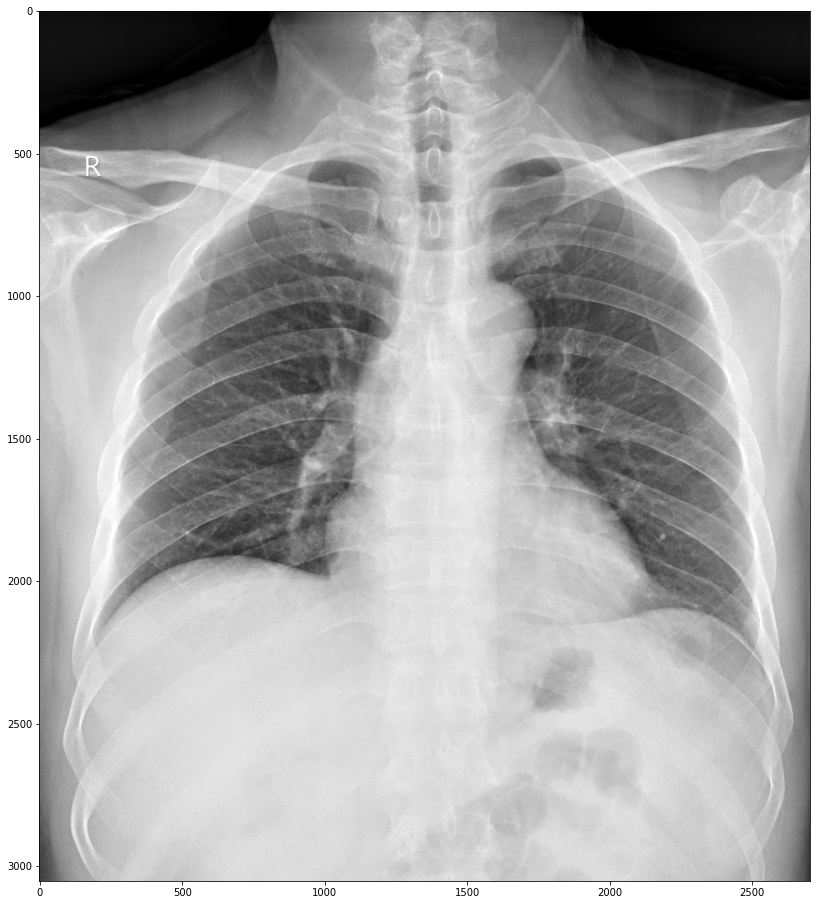

In [8]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(16, 16))
plt.imshow(arr, cmap="gray")

In [9]:
arr.shape

(3051, 2704)

## EDA

In [10]:
files 

['vinbigdata/sample_submission.csv',
 'vinbigdata/test/',
 'vinbigdata/train.csv',
 'vinbigdata/train/']

In [12]:
import pandas as pd 
import dask.dataframe as dd

df = dd.read_csv(f"az://{container_name}/train.csv", storage_options=storage_options).compute()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


In [13]:
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [14]:
df.tail()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0
67913,5e272e3adbdaafb07a7e84a9e62b1a4c,No finding,14,R16,NaN,NaN,NaN,NaN


In [15]:
df.describe()

,class_id,x_min,y_min,x_max,y_max
count,67914.000000,36096.000000,36096.000000,36096.000000,36096.000000
mean,9.979312,1051.332696,1065.262051,1492.269337,1456.660489
std,5.036494,565.838078,552.925133,595.384126,581.134138
min,0.000000,0.000000,0.000000,68.000000,103.000000
25%,7.000000,602.000000,627.000000,1010.000000,1009.000000
50%,13.000000,1014.500000,935.000000,1567.000000,1411.000000
75%,14.000000,1457.000000,1471.000000,1947.000000,1911.000000
max,14.000000,2934.000000,3133.000000,3131.000000,3384.000000


<AxesSubplot:>

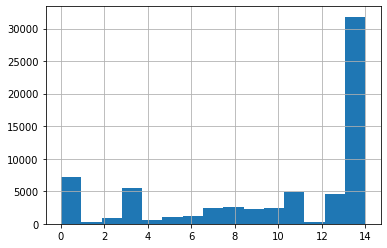

In [20]:
df.class_id.hist(bins=len(set(df.class_id)))

In [21]:
df.class_id.value_counts()

14    31818
0      7162
3      5427
11     4842
13     4655
8      2580
7      2483
10     2476
9      2203
6      1247
5      1000
2       960
4       556
1       279
12      226
Name: class_id, dtype: int64